## Submitted by Rizu Jain (430000753)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
df_train_raw = pd.read_csv("Train_data.csv")
df_val_raw = pd.read_csv("Validation_data.csv")
df_test_raw = pd.read_csv("Test_data.csv")

In [3]:
train_images = df_train_raw['pixels'].str.split(' ', expand=True)
val_images = df_val_raw['pixels'].str.split(' ', expand=True)
test_images = df_test_raw['pixels'].str.split(' ', expand=True)

train_labels = df_train_raw['emotion']
val_labels = df_val_raw['emotion']
test_labels = df_test_raw['emotion']

In [4]:
train_images_raw = train_images.apply(pd.to_numeric) 
val_images_raw = val_images.apply(pd.to_numeric)
test_images_raw = test_images.apply(pd.to_numeric)

## (a) (1 point) Visualization:

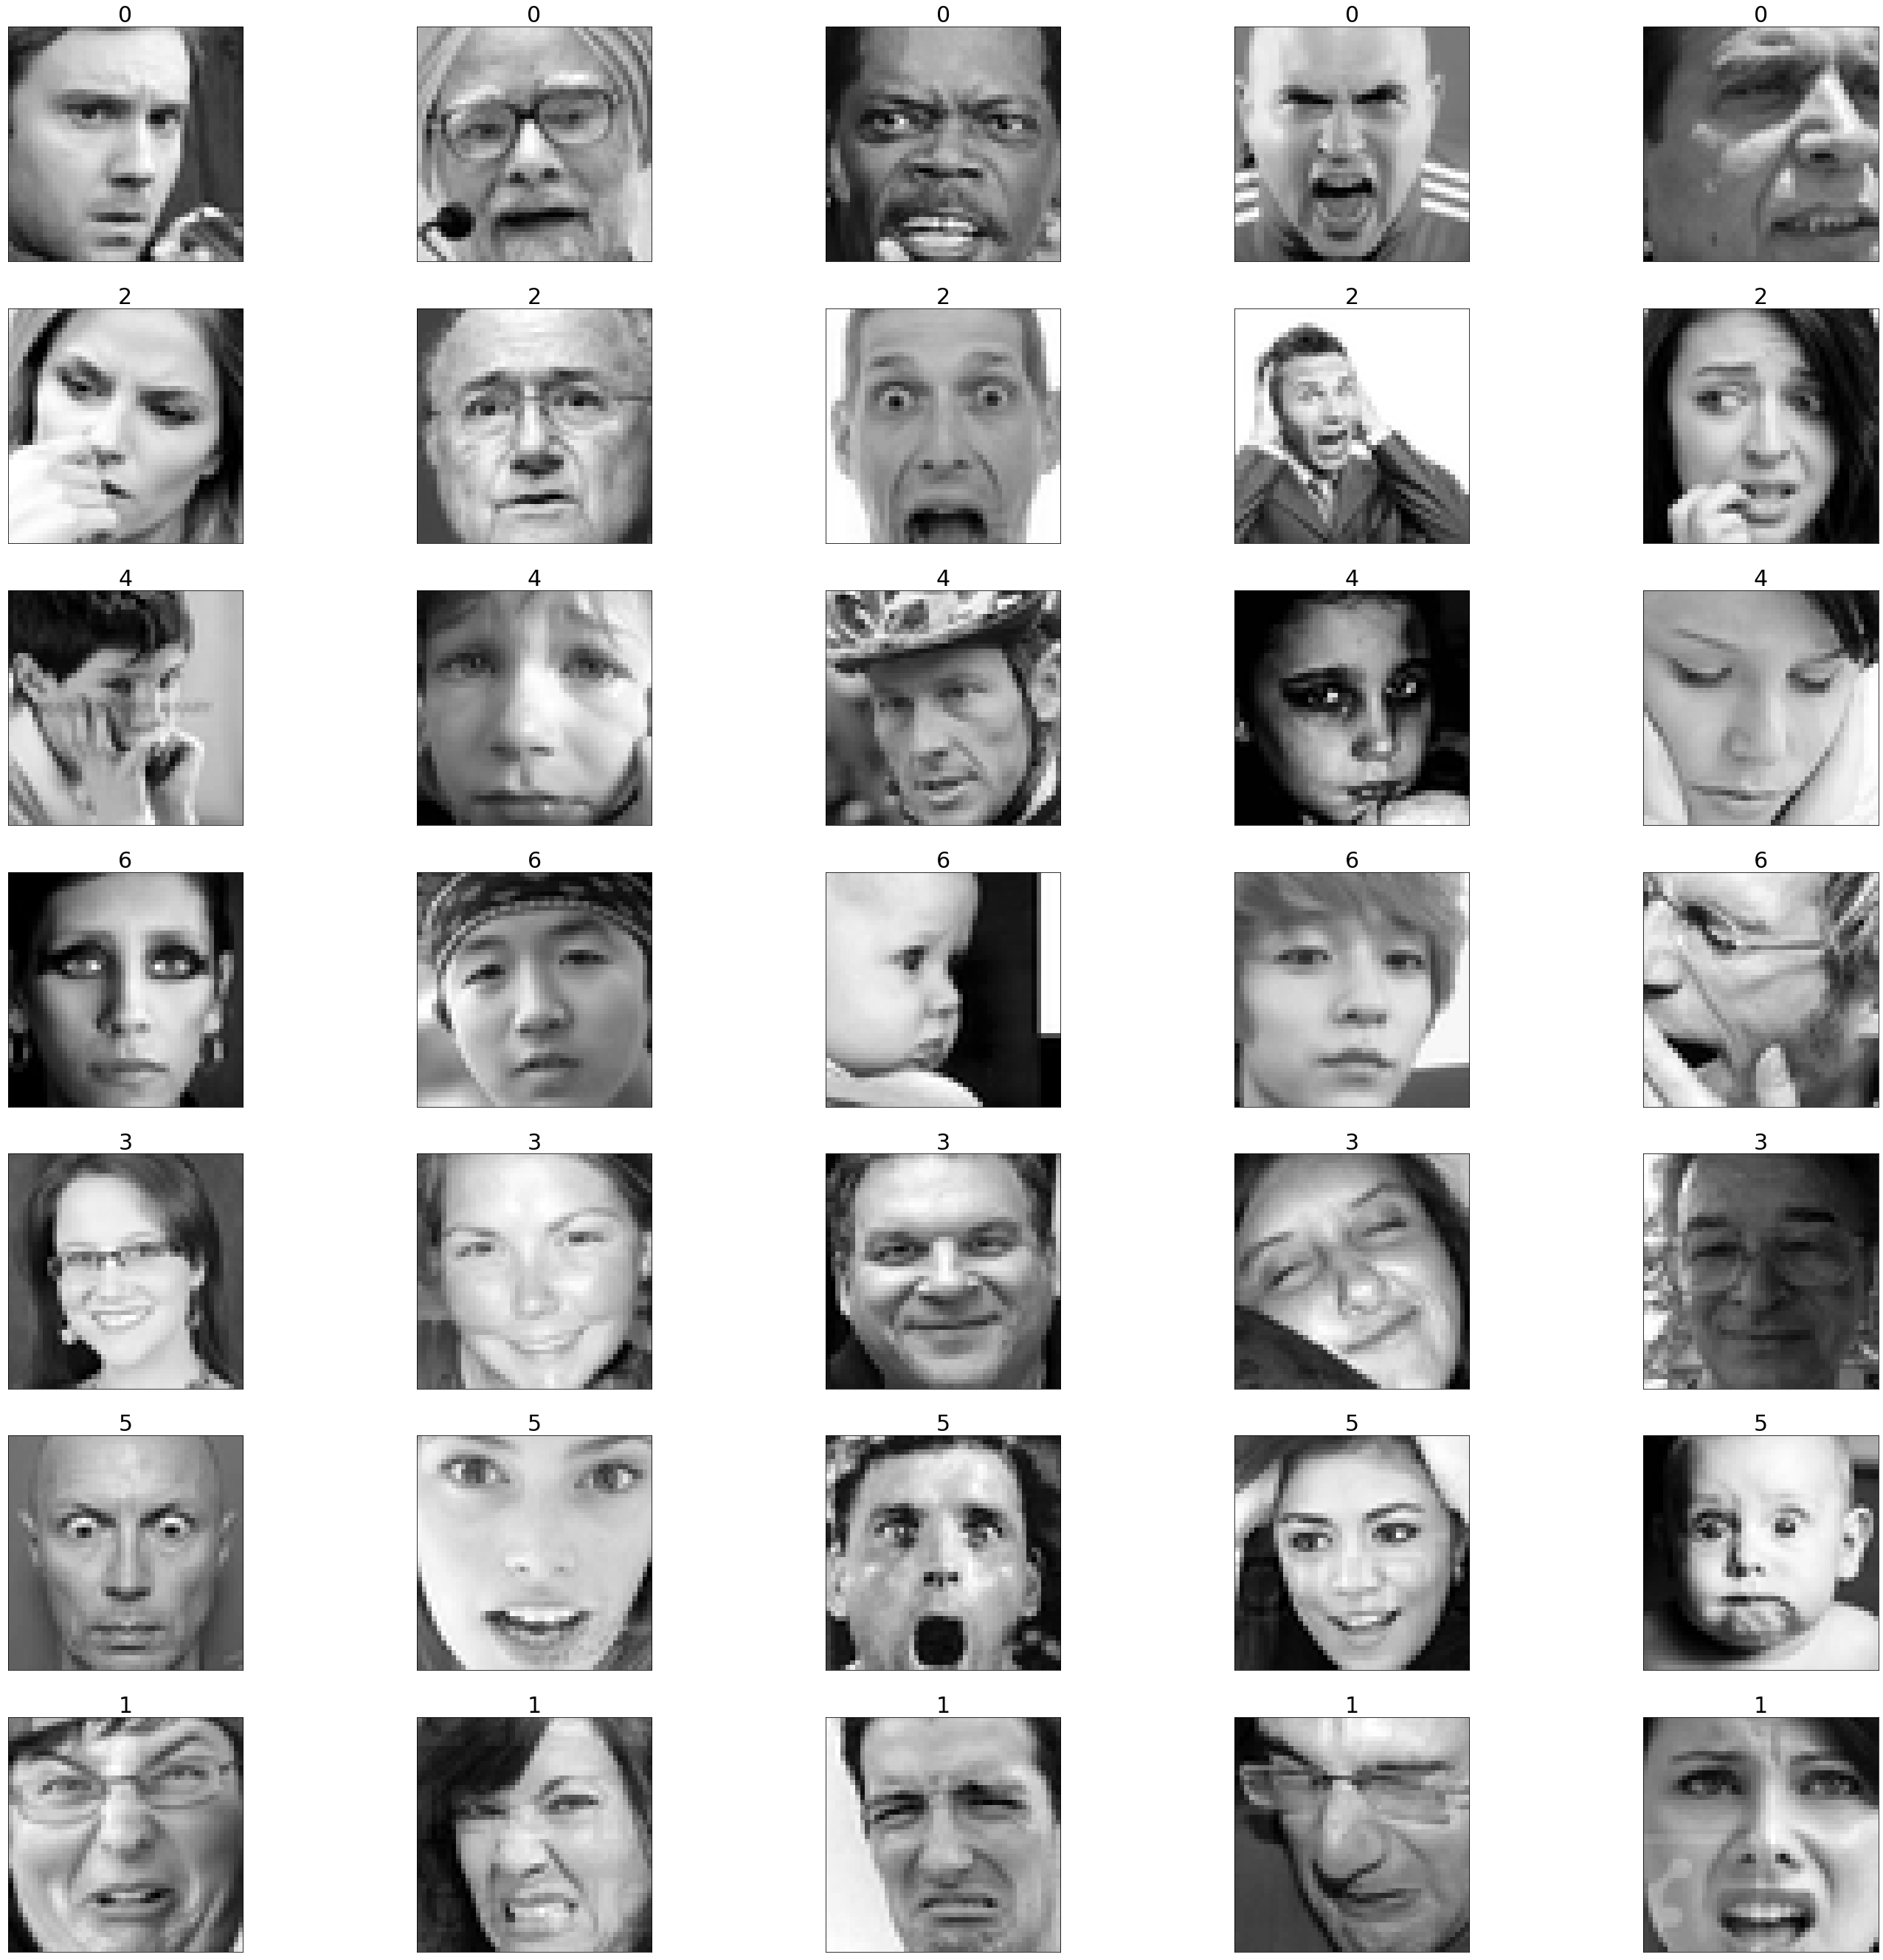

In [5]:
emotion_sample_images = {}
fig = plt.figure(figsize=(48,48))
pic_id = 0

for emotion in train_labels.unique():
    images_ids = train_labels.loc[train_labels == emotion].index
    emotion_sample_images[emotion] = images_ids[:5]
    
    for idx in images_ids[:5]:
        ax = fig.add_subplot(7, 5, pic_id+1, xticks=[], yticks=[])
        ax.imshow(train_images_raw.iloc[idx,:].values.reshape(48, 48), cmap='gray')
        ax.set_title(str(emotion),fontsize=30)
        pic_id += 1

    

## (b) (0.5 points) Data exploration:

In [6]:
train_labels.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [7]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.grid_search import b
from keras.utils import to_categorical

Using TensorFlow backend.


In [8]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.layers import Conv2D, Flatten, MaxPooling2D
from keras import backend as K 
from hyperopt import space_eval

import time
import random

In [9]:
# pre-processing
train_images_norm = (train_images_raw / 255) - 0.5
val_images_norm = (val_images_raw / 255) - 0.5
test_images_norm = (test_images_raw / 255) - 0.5

In [10]:
x_train_fnn = train_images_norm.copy()
x_val_fnn = val_images_norm.copy()
x_test_fnn = test_images_norm.copy()

In [11]:
y_train = to_categorical(train_labels)
y_val = to_categorical(val_labels)
y_test = to_categorical(test_labels)

In [12]:
n_input = train_images.shape[1]
n_class = train_labels.unique().shape[0]
print('feature num: ', n_input)
print('class num: ', n_class)

feature num:  2304
class num:  7


## (c) (3.5 points) Image classification with FNNs
## (c.i) (2.5 points)

In [13]:
K.clear_session()

In [14]:
def optimize_fnn(hyperparameter):
  K.clear_session()  
  fnn_model = Sequential()

  first_layer = True
  for layer_size in hyperparameter['network_config']:
    
    if first_layer:
        fnn_model.add(Dense(layer_size, input_dim = n_input, activation=hyperparameter['activation_function'],kernel_regularizer = l2(hyperparameter['l2_penalty']),))
        first_layer = False
    else:
        fnn_model.add(Dense(layer_size, activation=hyperparameter['activation_function'],kernel_regularizer = l2(hyperparameter['l2_penalty'])))

    fnn_model.add(Dropout(hyperparameter['dropout_prob']))

  fnn_model.add(Dense(n_class, activation='softmax'))

  fnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'],)

  train_X, train_y = train_images, y_train
  valid_X, valid_y = val_images, y_val

  start = time.time()
  fnn_history = fnn_model.fit(x_train_fnn, y_train, epochs=20, batch_size=256, verbose=0)
  end = time.time()

#   print(fnn_model.summary())

  performance_fnn = fnn_model.evaluate(x_val_fnn, y_val, verbose=0)

  print("----------------------------------------------------")

  print("Hyperparameters: ", (hyperparameter))
  print()
  print("No. of parameters : %d" % (fnn_model.count_params()))
  print("Training time : %.2f s" % (end-start))
  print("Training Accuracy : %.3f" % (fnn_history.history['accuracy'][-1]))
  print("Validation Accuracy : %.3f" % (performance_fnn[1]))
  print("----------------------------------------------------")
    
  if random.random() < 0.35:
    plt.plot(fnn_history.history['loss'])
    plt.title('Cross-entropy loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    print("----------------------------------------------------")

# We want to minimize loss i.e. negative of accuracy
  return({"status": STATUS_OK, "loss": -1*performance_fnn[1], "model":fnn_model})


----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'relu', 'dropout_prob': 0.2658661419495981, 'l2_penalty': 0.001, 'network_config': (32, 32, 32), 'optimizer': 'Adam'}
No. of parameters : 76103                                                                                              
Training time : 38.27 s                                                                                                
Training Accuracy : 0.390                                                                                              
Validation Accuracy : 0.400                                                                                            
----------------------------------------------------                                                                   
------------------

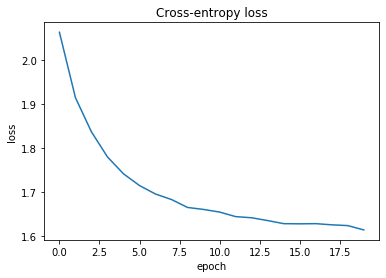

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'tanh', 'dropout_prob': 0.1781299110474086, 'l2_penalty': 0.03, 'network_config': (32, 32, 32), 'optimizer': 'Adam'}
No. of parameters : 76103                                                                                              
Training time : 39.20 s                                                                                                
Training Accuracy : 0.318                                                                                              
Validation Accuracy : 0.339                                                                                            
-------------------

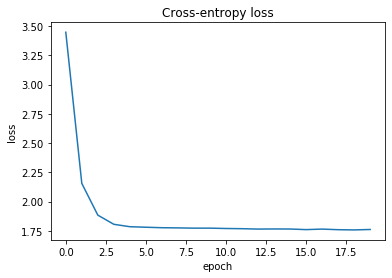

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'tanh', 'dropout_prob': 0.33285994826713994, 'l2_penalty': 0.003, 'network_config': (32, 64, 128), 'optimizer': 'Adam'}
No. of parameters : 85095                                                                                              
Training time : 39.04 s                                                                                                
Training Accuracy : 0.359                                                                                              
Validation Accuracy : 0.372                                                                                            
----------------

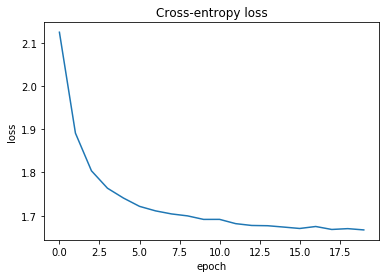

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'tanh', 'dropout_prob': 0.33050577093499756, 'l2_penalty': 0.03, 'network_config': (32, 32, 32), 'optimizer': 'Adam'}
No. of parameters : 76103                                                                                              
Training time : 37.62 s                                                                                                
Training Accuracy : 0.311                                                                                              
Validation Accuracy : 0.318                                                                                            
------------------

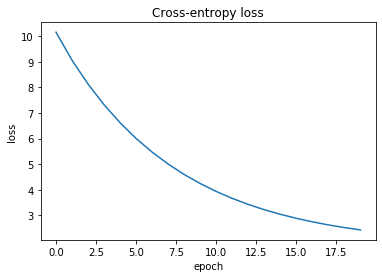

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'relu', 'dropout_prob': 0.17663707686718594, 'l2_penalty': 0.03, 'network_config': (64, 64), 'optimizer': 'sgd'}
No. of parameters : 152135                                                                                             
Training time : 38.40 s                                                                                                
Training Accuracy : 0.335                                                                                              
Validation Accuracy : 0.359                                                                                            
-----------------------

In [15]:
# Define search space for hyper-parameters
space_fnn = {
    # The kernel_size for convolutions:
    'network_config': hp.choice('network_config', [[32,32,32],[32,64,128],[64,64],[64,128,64]]),
    # The stride_size for convolutions:
    'activation_function': hp.choice('activation_function', ['tanh', 'relu']),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.35),
    # regularization:
    'l2_penalty': hp.choice('l2_penalty', [0.001,0.003,0.01,0.03]),
    # Choice of optimizer 
    'optimizer': hp.choice('optimizer', ['Adam','sgd']),
}

trials_fnn = Trials()

# Find the best hyperparameters
best_fnn = fmin(
        optimize_fnn,
        space_fnn,
        algo=tpe.suggest,
        trials=trials_fnn,
        max_evals=10,
    )


## (c.ii) (1 point)

In [16]:
print("==================================")
print("Best Hyperparameters", best_fnn)

best_hyper_fnn = space_eval(space_fnn,best_fnn)
fnn_tuned = optimize_fnn(best_hyper_fnn)

performance_fnn = fnn_tuned['model'].evaluate(x_test_fnn, y_test,verbose=0)

print("==================================")
print("Test Accuracy: ", performance_fnn[1])

Best Hyperparameters {'activation_function': 1, 'dropout_prob': 0.34525558508915966, 'l2_penalty': 0, 'network_config': 3, 'optimizer': 0}
----------------------------------------------------
Hyperparameters:  {'activation_function': 'relu', 'dropout_prob': 0.34525558508915966, 'l2_penalty': 0.001, 'network_config': (64, 128, 64), 'optimizer': 'Adam'}

No. of parameters : 164551
Training time : 40.88 s
Training Accuracy : 0.405
Validation Accuracy : 0.408
----------------------------------------------------
Test Accuracy:  0.40930622816085815


### FNN accuracy on test set: 0.4093

In [17]:
x_train_cnn = train_images_norm.values.reshape((-1,48,48,1))
x_val_cnn = val_images_norm.values.reshape((-1,48,48,1))
x_test_cnn = test_images_norm.values.reshape((-1,48,48,1))

## (d) (3 points) Image classification with CNNs:

## (d.i) (2 points)

In [18]:
def optimize_cnn(hyperparameter):
  K.clear_session()  
  cnn_model = Sequential()

  for layer_sequence in hyperparameter['conv2d_config']:
    for layer_size in layer_sequence:
        cnn_model.add(Conv2D(layer_size, kernel_size=hyperparameter['conv_kernel_size'],padding='same', strides=hyperparameter['stride_size'], activation=hyperparameter['activation_function']))
    cnn_model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    cnn_model.add(Dropout(hyperparameter['dropout_prob']))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(hyperparameter['dense_layer_neurons'], activation=hyperparameter['activation_function']))

  cnn_model.add(Dense(7, activation='softmax'))

  cnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'],)

  start = time.time()
  cnn_history = cnn_model.fit(x_train_cnn, y_train, epochs=20, batch_size=256, verbose=0)
  end = time.time()

#   print(cnn_model.summary())

  performance = cnn_model.evaluate(x_val_cnn, y_val, verbose=0)

  print("----------------------------------------------------")

  print("Hyperparameters: ", (hyperparameter))
  print()
  print("No. of parameters : %d" % (cnn_model.count_params()))
  print("Training time : %.2f s" % (end-start))
  print("Training Accuracy : %.3f" % (cnn_history.history['accuracy'][-1]))
  print("Validation Accuracy : %.3f" % (performance[1]))
  print("----------------------------------------------------")
    
  if random.random() < 0.35:
    plt.plot(cnn_history.history['loss'])
    plt.title('Cross-entropy loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    print("----------------------------------------------------")

# We want to minimize loss i.e. negative of accuracy
  return({"status": STATUS_OK, "loss": -1*performance[1], "model":cnn_model})


----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'tanh', 'conv2d_config': ((32, 32), (64, 64)), 'conv_kernel_size': 1, 'dense_layer_neurons': 128, 'dropout_prob': 0.14596884626860737, 'optimizer': 'sgd', 'stride_size': 1}
No. of parameters : 1188071                                                                                            
Training time : 848.58 s                                                                                               
Training Accuracy : 0.401                                                                                              
Validation Accuracy : 0.378                                                                                            
----------------------------------------------------                               

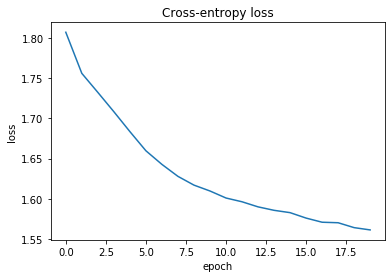

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'relu', 'conv2d_config': ((32, 32), (64, 64)), 'conv_kernel_size': 3, 'dense_layer_neurons': 256, 'dropout_prob': 0.2911961806773443, 'optimizer': 'Adam', 'stride_size': 1}
No. of parameters : 2426343                                                                                            
Training time : 3183.59 s                                                                                              
Training Accuracy : 0.947                                                                                              
Validation Accuracy : 0.587                                                        

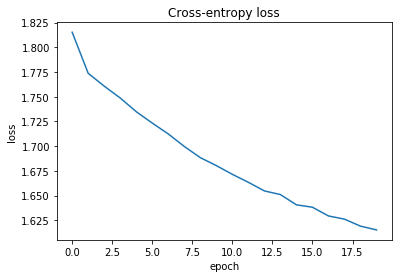

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'tanh', 'conv2d_config': ((32, 32), (64, 64)), 'conv_kernel_size': 3, 'dense_layer_neurons': 256, 'dropout_prob': 0.34119556919902994, 'optimizer': 'sgd', 'stride_size': 2}
No. of parameters : 83431                                                                                              
Training time : 183.41 s                                                                                               
Training Accuracy : 0.290                                                                                              
Validation Accuracy : 0.314                                                        

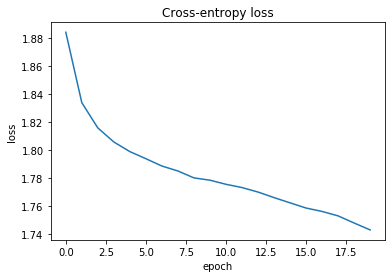

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'tanh', 'conv2d_config': ((32, 32), (64, 64)), 'conv_kernel_size': 3, 'dense_layer_neurons': 256, 'dropout_prob': 0.2818391037926066, 'optimizer': 'sgd', 'stride_size': 1}
No. of parameters : 2426343                                                                                            
Training time : 2536.79 s                                                                                              
Training Accuracy : 0.417                                                                                              
Validation Accuracy : 0.411                                                         

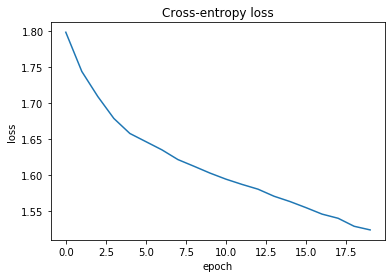

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'tanh', 'conv2d_config': ((32,), (64,), (128,)), 'conv_kernel_size': 5, 'dense_layer_neurons': 256, 'dropout_prob': 0.13736009970345767, 'optimizer': 'Adam', 'stride_size': 2}
No. of parameters : 291847                                                                                             
Training time : 310.60 s                                                                                               
Training Accuracy : 0.815                                                                                              
Validation Accuracy : 0.539                                                     

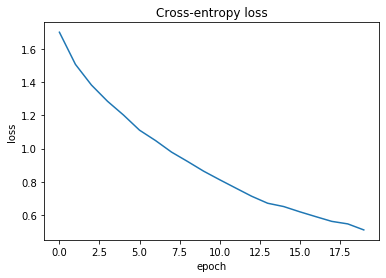

----------------------------------------------------                                                                   
----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'relu', 'conv2d_config': ((32,), (64,), (128,)), 'conv_kernel_size': 5, 'dense_layer_neurons': 128, 'dropout_prob': 0.25213564993880666, 'optimizer': 'Adam', 'stride_size': 2}
No. of parameters : 274439                                                                                             
Training time : 362.60 s                                                                                               
Training Accuracy : 0.596                                                                                              
Validation Accuracy : 0.549                                                     

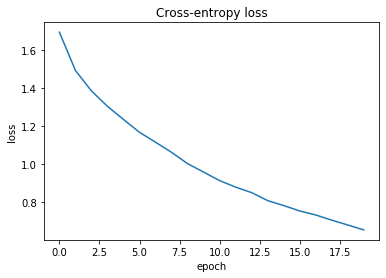

----------------------------------------------------                                                                   
100%|████████████████████████████████████████████| 10/10 [2:43:27<00:00, 980.72s/trial, best loss: -0.5865143537521362]


In [19]:
# Define search space for hyper-parameters
space_cnn = {
    # The convolution layers and sizes
    'conv2d_config': hp.choice('conv2d_config', [[[32,32],[64,64]],[[32],[64],[128]]]),
    # The last dense layer size
    'dense_layer_neurons': hp.choice('dense_layer_neurons', [128,256]),
    # The kernel_size for convolutions:
    'conv_kernel_size': hp.choice('conv_kernel_size', [1, 3, 5]),
    # The stride_size for convolutions:
    'stride_size': hp.choice('stride_size', [1, 2]),
    # The activation function
    'activation_function': hp.choice('activation_function', ['tanh', 'relu']),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.35),
    # Choice of optimizer 
    'optimizer': hp.choice('optimizer', ['Adam','sgd']),
}

trials_cnn = Trials()

# Find the best hyperparameters
best_cnn = fmin(
        optimize_cnn,
        space_cnn,
        algo=tpe.suggest,
        trials=trials_cnn,
        max_evals=10,
    )

Best Hyperparameters {'activation_function': 1, 'conv2d_config': 0, 'conv_kernel_size': 1, 'dense_layer_neurons': 1, 'dropout_prob': 0.2911961806773443, 'optimizer': 0, 'stride_size': 0}
----------------------------------------------------
Hyperparameters:  {'activation_function': 'relu', 'conv2d_config': ((32, 32), (64, 64)), 'conv_kernel_size': 3, 'dense_layer_neurons': 256, 'dropout_prob': 0.2911961806773443, 'optimizer': 'Adam', 'stride_size': 1}

No. of parameters : 2426343
Training time : 5303.13 s
Training Accuracy : 0.949
Validation Accuracy : 0.582
----------------------------------------------------


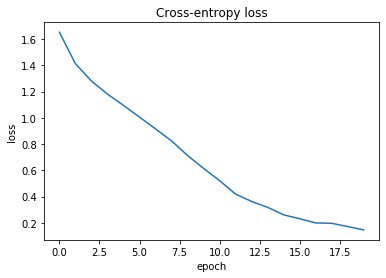

----------------------------------------------------
Test Accuracy:  0.5828921794891357


In [20]:
print("==================================")
print("Best Hyperparameters", best_cnn)

best_hyper_cnn = space_eval(space_cnn,best_cnn)
cnn_tuned = optimize_cnn(best_hyper_cnn)

performance_cnn = cnn_tuned['model'].evaluate(x_test_cnn, y_test,verbose=0)

print("==================================")
print("Test Accuracy: ", performance_cnn[1])

### CNN accuracy on test set: 0.5829

### FNN and CNN comparision

|  | FNN | CNN |
| --- | --- | --- |
| No. of parameters | < 200K | > 1M |
| Training time | < 1 min | > 5 min |
| Best Training accuracy | 0.405 | 0.949 |
| Best Validation accuracy | 0.408 | 0.582 |
| Test accuracy | 0.409 | 0.582|

### Conclusion: We get improvement in our predictions using CNN over FNN.

## (d) (2 points) Fine-tuning:

In [21]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model, load_model
from keras.datasets import mnist

In [22]:
# Convert the images into 3 channels
x_train_rgb=np.dstack([train_images_norm] * 3)
x_val_rgb=np.dstack([val_images_norm]*3)
x_test_rgb=np.dstack([test_images_norm]*3)
x_train_vgg = x_train_rgb.reshape(-1,48,48,3)
x_val_vgg= x_val_rgb.reshape (-1,48,48,3)
x_test_vgg= x_test_rgb.reshape (-1,48,48,3)

In [23]:
fer_shape = x_train_vgg.shape[1:]

In [27]:
def optimize_vgg(hyperparameter):
    K.clear_session()
    vgg_pretrain = VGG16(weights='imagenet', include_top=False)

    for layer in vgg_pretrain.layers[:hyperparameter['unfreeze_layers']]:
        layer.trainable = False

    fer_input = Input(shape=fer_shape, name = 'image_input')
    vgg_output = vgg_pretrain(fer_input)
    x = Flatten(name='flatten')(vgg_output)

    for layer_size in hyperparameter['add_config']:
        x = Dense(layer_size, activation=hyperparameter['activation_function'],kernel_regularizer = l2(hyperparameter['l2_penalty']))(x)
        x = Dropout(hyperparameter['dropout_prob'])(x)

    x = Dense(n_class, activation='softmax', name='predictions')(x)
    
    fer_pretrained = Model(inputs=fer_input, outputs=x)
    fer_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    start = time.time()
    vgg_history = fer_pretrained.fit(x_train_vgg, y_train, epochs=2, batch_size=256, verbose=0)
    end = time.time()

    performance = fer_pretrained.evaluate(x_val_vgg, y_val, verbose=0)

    print("----------------------------------------------------")

    print("Hyperparameters: ", (hyperparameter))
    print()
    print("No. of parameters : %d" % (fer_pretrained.count_params()))
    print("Training time : %.2f s" % (end-start))
    print("Training Accuracy : %.3f" % (vgg_history.history['accuracy'][-1]))
    print("Validation Accuracy : %.3f" % (performance[1]))
    print("----------------------------------------------------")

    if random.random() < 0.35:
        plt.plot(vgg_history.history['loss'])
        plt.title('Cross-entropy loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()
        print("----------------------------------------------------")

    # We want to minimize loss i.e. negative of accuracy
    return({"status": STATUS_OK, "loss": -1*performance[1], "model":fer_pretrained})


In [28]:
# Define search space for hyper-parameters
space_vgg = {
    # The convolution layers and sizes
    'add_config': hp.choice('add_config', [[128,32],[256,64]]),
    # The activation function
    'activation_function': hp.choice('activation_function', ['tanh', 'relu']),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.35),
    'unfreeze_layers': hp.choice('unfreeze_layers', [4,5]),
    # regularization:
    'l2_penalty': hp.choice('l2_penalty', [0.001,0.003,0.01,0.03]),
}

trials_vgg = Trials()

# Find the best hyperparameters
best_vgg = fmin(
        optimize_vgg,
        space_vgg,
        algo=tpe.suggest,
        trials=trials_vgg,
        max_evals=5,
    )

----------------------------------------------------                                                                   
Hyperparameters:                                                                                                       
{'activation_function': 'relu', 'add_config': (128, 32), 'dropout_prob': 0.18526718592673108, 'l2_penalty': 0.01, 'unfreeze_layers': 4}
No. of parameters : 14784711                                                                                           
Training time : 530.47 s                                                                                               
Training Accuracy : 0.221                                                                                              
Validation Accuracy : 0.249                                                                                            
----------------------------------------------------                                                                   
------------------------

Best Hyperparameters {'activation_function': 1, 'add_config': 0, 'dropout_prob': 0.18526718592673108, 'l2_penalty': 2, 'unfreeze_layers': 0}
----------------------------------------------------
Hyperparameters:  {'activation_function': 'relu', 'add_config': (128, 32), 'dropout_prob': 0.18526718592673108, 'l2_penalty': 0.01, 'unfreeze_layers': 4}

No. of parameters : 14784711
Training time : 404.27 s
Training Accuracy : 0.242
Validation Accuracy : 0.249
----------------------------------------------------


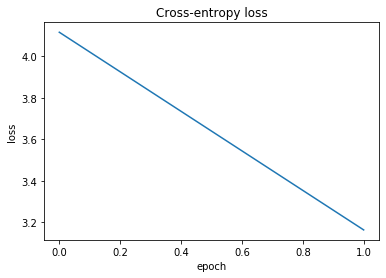

----------------------------------------------------
Test Accuracy:  0.24491502344608307


In [29]:
print("==================================")
print("Best Hyperparameters", best_vgg)

best_hyper_vgg = space_eval(space_vgg,best_vgg)
vgg_tuned = optimize_vgg(best_hyper_vgg)

performance_vgg = vgg_tuned['model'].evaluate(x_test_vgg, y_test,verbose=0)

print("==================================")
print("Test Accuracy: ", performance_vgg[1])

### Fine-Tuning accuracy on the test set: 0.2449